# Binomial, Poisson and Gaussian distributions

Python notebook for illustrating the Binomial, Poisson and Gaussian distributions and how they in certain limits converge towards each other (and in the end into the Gaussian). The notebook also illustrates simple fitting.

## References:
- Barlow: Chapter 3
- Cowan: Chapter 2
- Particle Data Group: __["Probability theorem and distributions"](https://pdg.lbl.gov/2022/reviews/rpp2022-rev-probability.pdf)__

## Author(s), contact(s), and dates:
- Author: Troels C. Petersen (NBI)
- Email:  petersen@nbi.dk
- Date:   21st of November 2024

***

In [3]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit import cost
from scipy import stats
from scipy.stats import binom, poisson, norm

Note that `SciPy Stats` has nearly every conceivable function implemented:
__["SciPy Stats functions"](https://docs.scipy.org/doc/scipy/reference/stats.html)__

In [109]:
# General settings:
r = np.random                       # Random generator
r.seed(42)                          # Fixed order of random numbers

save_plots = False
verbose = True
N_verbose = 10

# Set plotting parameters:
plt.rcParams['font.size'] = 18      # Set the general plotting font size

# Plotting PDFs:

First, we want to have a look at the three PDFs (Binomial, Poisson, and Gaussian), and compare them given "the same" parameters. Of course we can't give the same input parameters, but at least we can require that they have the same mean and widths... Almost - one can not force the width of the Poisson to match that of the Binomial, once the mean is matched. The Gaussian will then have to choose between these two slightly different widths!

### Problem parameters:
* The Binomial PDF needs two parameters: Number of trials (n) and probability of succes (p).
* The Poisson PDF needs one parameter:  The expected number (lambda - but in Python we write it "Lambda" or "lamp", as "lambda" is reserved!).
* The Gaussian PDF needs two parameters: Mean (mu) and width (sigma).

In [110]:
def func_binomial_pmf(x, n, p):
    return binom.pmf(x, n, p)

In [111]:
def func_poisson_pmf(x, lamb):
    return poisson.pmf(x, lamb)

In [112]:
def func_gaussian_pdf(x, mu, sigma) :
    return norm.pdf(x, mu, sigma)

In [121]:
# Range of outcome:
xmin = -5
xmax = 13.5

# Function parameters:
# Binomial:
n = 10
p = 0.2

# Poisson:
Lambda = n * p               # We choose this, as this is the expected number of successes (capital "L" to not copy python command!).

# Gaussian:
mu = Lambda                  # Same here - the central value is n*p.
#sigma = np.sqrt(n*p*(1-p))   # For a Binomial process, the variance is n*p*(1-p)
sigma = np.sqrt(n*p)         # Alternatively, one can use the Poisson width.
                             # Note how for small values of p, these expressions are essentially the same!!!

In [114]:
# Note that the np.floor function takes the integer/rounded (towards zero) value of numbers.
xaxis = np.linspace(xmin, xmax, 1000)
yaxis_binom = func_binomial_pmf(np.floor(xaxis+0.5), n, p)
yaxis_poiss = func_poisson_pmf(np.floor(xaxis+0.5), Lambda)
yaxis_gauss = func_gaussian_pdf(xaxis, n*p, sigma)


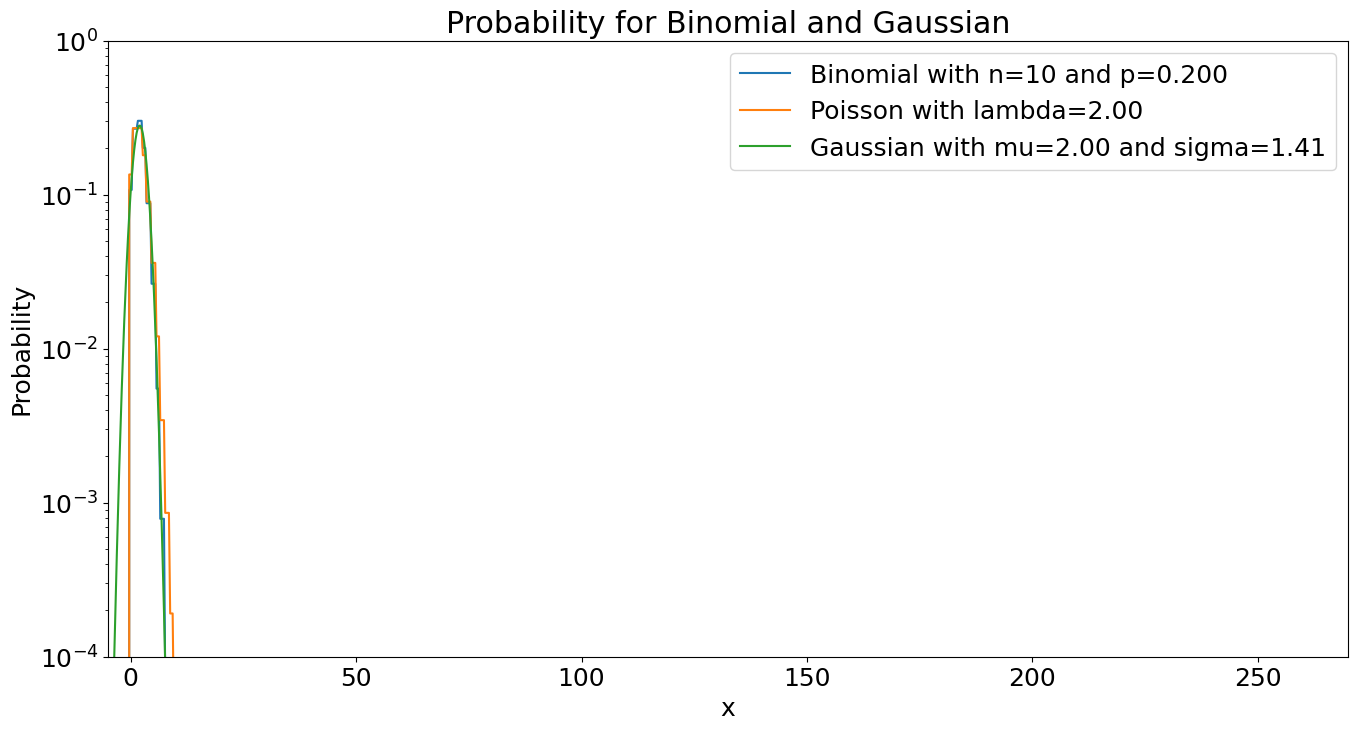

In [115]:
fig0, ax0 = plt.subplots(figsize=(16, 8))
ax0.plot(xaxis, yaxis_binom, '-', label=f'Binomial with n={n:2d} and p={p:.3f}')
ax0.plot(xaxis, yaxis_poiss, '-', label=f'Poisson with lambda={Lambda:.2f}')
ax0.plot(xaxis, yaxis_gauss, '-', label=f'Gaussian with mu={mu:.2f} and sigma={sigma:.2f}')
ax0.set(xlim=(xmin, xmax),
        title='Probability for Binomial and Gaussian', 
        xlabel='x', 
        ylabel='Probability')
ax0.set_yscale('log')
ax0.set_ylim(1e-4, 1.0)
ax0.legend(loc='upper right');

# Looping over processes:
In the following we simulate a Binomial/Poisson process with given parameters, i.e. number of trials and probability of success. For the Poisson, these can not be specified, but the resulting expected number is naturally lambda = n * p.

After having simulated the process, we fit the result with the three distributions in question, and test to what extend they match.

In [116]:
# Simulation parameters:
N_experiments = 1000              # Number of simulations/experiments to perform

N_trials = n                      # Number of trials in each experiment (taken from above!)
p_success = p                     # Chance of succes in each trial (taken from above!)
Lambda = N_trials * p_success     # This is the mean and the one parameter by which the Poisson is defined!

print(f"  With N_trials = {N_trials:d} and p_success = {p_success:.4f}, the average number of successes is lambda = {Lambda:.2f}")

  With N_trials = 10 and p_success = 0.2000, the average number of successes is lambda = 2.00


In [117]:

all_n_success = np.zeros(N_experiments)

# Run the experiments, and fill the histogram from above:
for iexp in range(N_experiments): 
    
    # Simulating process defined:
    n_success = 0
    for i in range(N_trials): 
        x = r.uniform()
        if (x < p_success): 
            n_success += 1

    # Record result:
    if (verbose and iexp < N_verbose): 
        print(f"n_success: {n_success:4d}")
        
    # Save Result
    all_n_success[iexp] = n_success

n_success:    3
n_success:    3
n_success:    3
n_success:    3
n_success:    3
n_success:    3
n_success:    2
n_success:    4
n_success:    1
n_success:    3


## Plot result:

Define a histogram with the "data" (note and think about the binning!). Also, ask yourself what uncertainty to assign to each bin?<br>
The line of thinking should be: "There are many possibilities of ending up in a specific bin, but the probability of doing so is low".

In [122]:
counts, bin_edges = np.histogram(all_n_success, bins=N_trials+1, range=(-0.5, N_trials+0.5))
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
s_counts = np.sqrt(counts)             # NOTE: We (naturally) assume that the bin count is Poisson distributed.

In [123]:
# We remove any bins, which don't have any counts in them (for Chi2 fitting):
x = bin_centers[counts>0]
y = counts[counts>0]
sy = s_counts[counts>0]

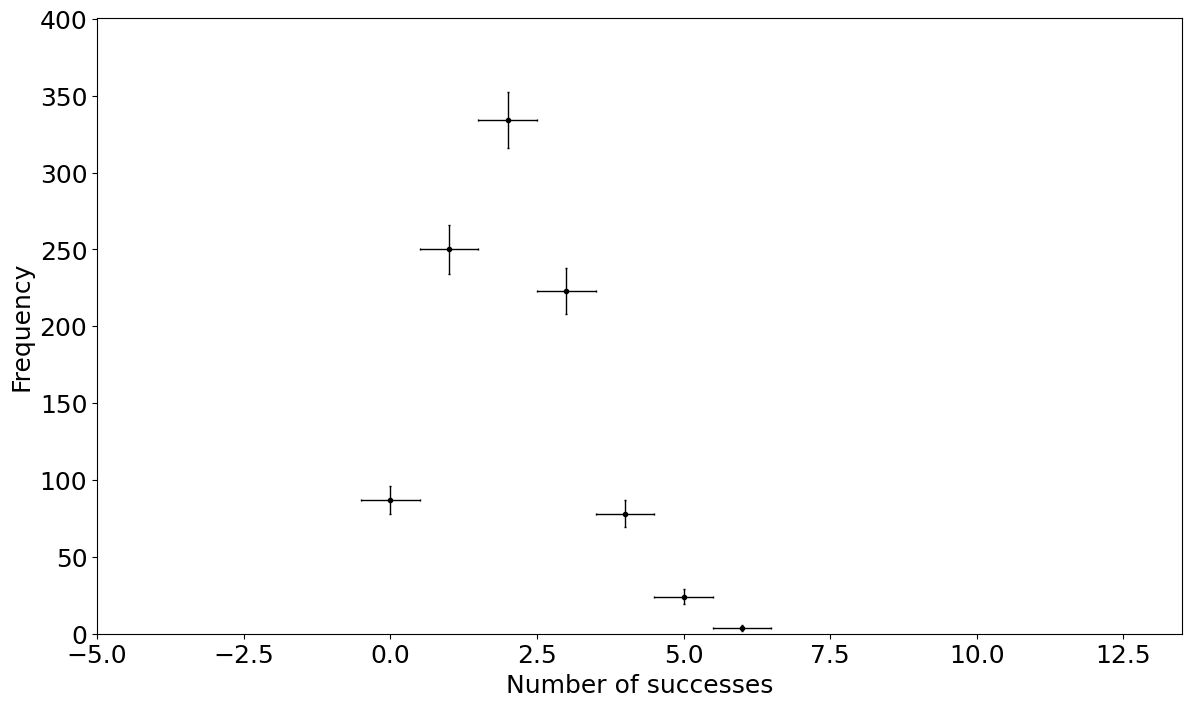

In [124]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.errorbar(x, y, yerr=sy, xerr=0.5, label='Distribution of nSuccesses', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)
ax.set(xlim=(xmin, xmax), ylim=(0, 1.2*np.max(y)), xlabel='Number of successes', ylabel='Frequency');

## Fitting with a Binomial:

First define the (fitting) function. It seems that the binomial function in scipy has a "feature" (bug?) that makes it unfit for fitting (pun not intended). For this reason, we have coded up our own binomial function below.  

In [125]:
def func_binomial(x, N, n, p):
    return N * binom.pmf(x, n, p)

In [126]:
from scipy.special import gammaln

def log_binomial_coefficient(n, x):
    # Use gammaln for better numerical stability with large numbers
    return gammaln(n + 1) - (gammaln(x + 1) + gammaln(n - x + 1))

def binomial_pmf(x, n, p):
    return np.exp(log_binomial_coefficient(n, x) + x * np.log(p) + (n - x) * np.log(1 - p))

def func_binomial_2(x_array, N, n, p):
    return N * binomial_pmf(x_array, n, p)

Cross check that the two functions give "same" results (without the bug).

Plot the functions with little shift (x+0.05 and x-0.05) for check…

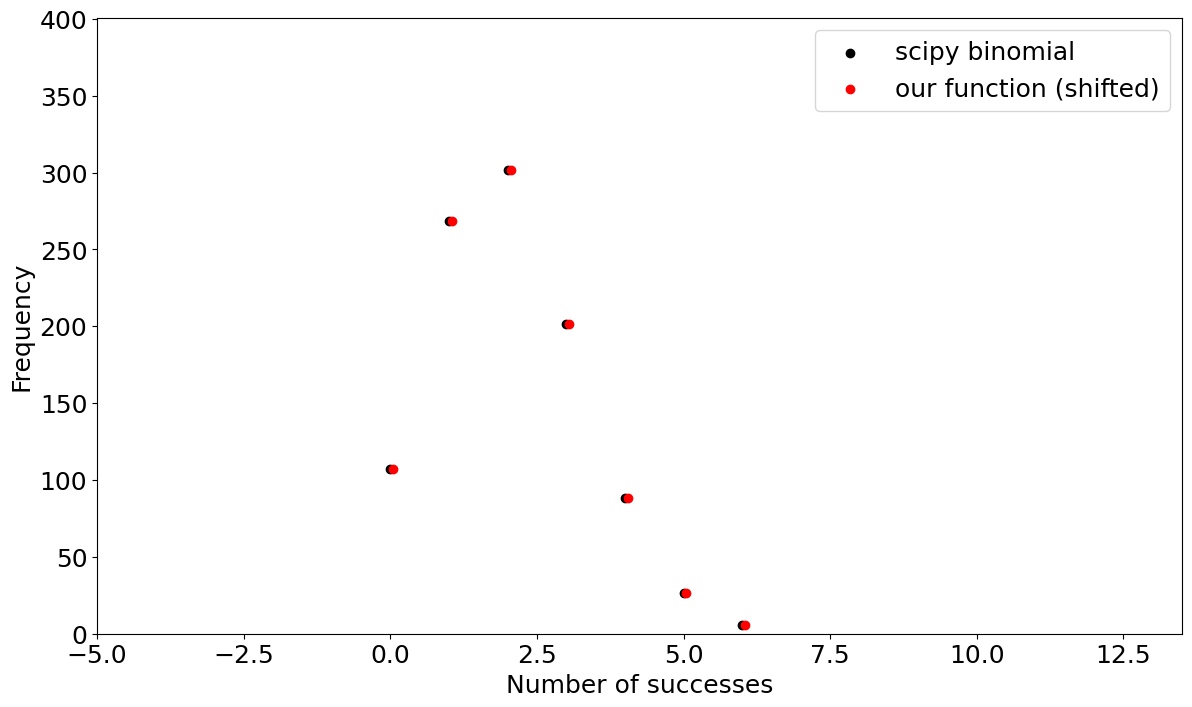

In [127]:
fig2, ax2 = plt.subplots(figsize=(14, 8))
ax2.set(xlim=(xmin, xmax), ylim=(0, 1.2*np.max(y)), xlabel='Number of successes', ylabel='Frequency')

ax2.scatter(x,  func_binomial(x, N_experiments, N_trials, p_success), color='k', label='scipy binomial')
ax2.scatter(x+0.05, func_binomial_2(x, N_experiments, N_trials, p_success), color='r', label='our function (shifted)')

ax2.legend()
plt.show()

Then fit it with a $\chi^2$-fit:

In [128]:
Minuit.print_level = 1      # This sets the level of printing when fitting with Minuit

chi2_bin = cost.LeastSquares(x, y, sy,func_binomial_2)
mfit_bin = Minuit(chi2_bin, N=N_experiments, n=N_trials, p=p_success) #   
mfit_bin.migrad()          # Perform the actual fit

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.181 (χ²/ndof = 0.8)      │              Nfcn = 116              │
│ EDM = 3.1e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N    │    997    │    32     │            │            │         │         │       │
│ 1 │ n    │    6.7    │    0.7    │            │            │         │         │       │
│ 2 │ p    │   0.303   │   0.032   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────┐
│   │       N       n       p │
├───┼─────────────────────────┤
│ N │     997     0.1 -0.0045 │
│ n │     0.1   0.515 -0.0227 │
│ p │ -0.0045 -0.0227 0.00103 │
└───┴─────────────────────────┘

And plot it on the figure:

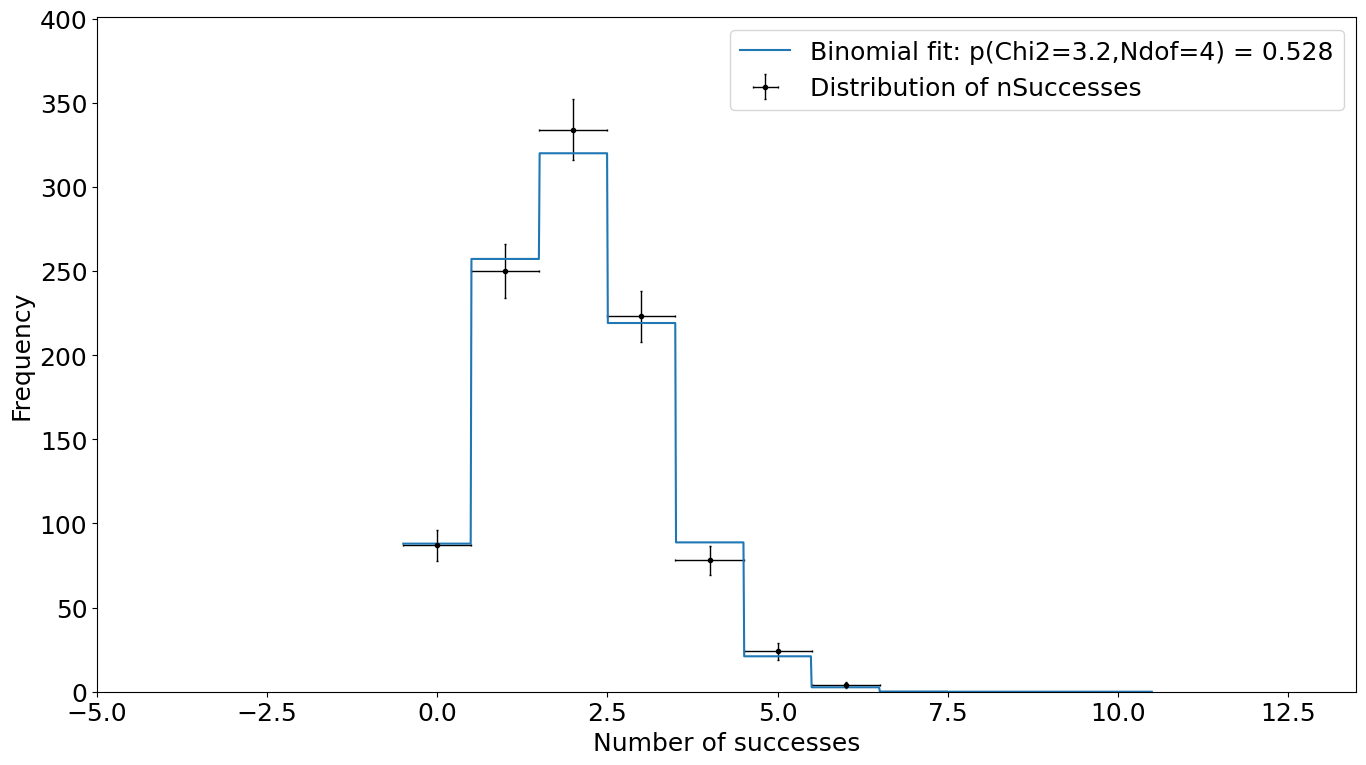

In [129]:
Chi2_bin = mfit_bin.fval
Ndof_bin = len(x) - 3        # 3 parameters in fit
Prob_bin = stats.chi2.sf(Chi2_bin, Ndof_bin)

xaxis = np.linspace(-0.5, N_trials+0.5, 1000)                  # This way we include all possibilties!
yaxis = func_binomial_2(np.floor(xaxis+0.5), *mfit_bin.values[:])
ax.plot(xaxis, yaxis, '-', label=f'Binomial fit: p(Chi2={Chi2_bin:.1f},Ndof={Ndof_bin:d}) = {Prob_bin:.3f}')
ax.legend()
fig.tight_layout()
fig

## Fitting with a Poisson:

In [130]:
def func_poisson(x, N, mu) :
    return N * poisson.pmf(x, mu)

In [131]:
chi2_poisson = cost.LeastSquares(x, y, sy, func_poisson)
mfit_poisson = Minuit(chi2_poisson, N=N_experiments, mu=Lambda) #   
mfit_poisson.migrad();             # Perform the actual fit (without printing/plotting)
Chi2_poi = mfit_poisson.fval
Ndof_poi = len(x) - 2              # 2 parameters in fit
Prob_poi = stats.chi2.sf(Chi2_poi, Ndof_poi)

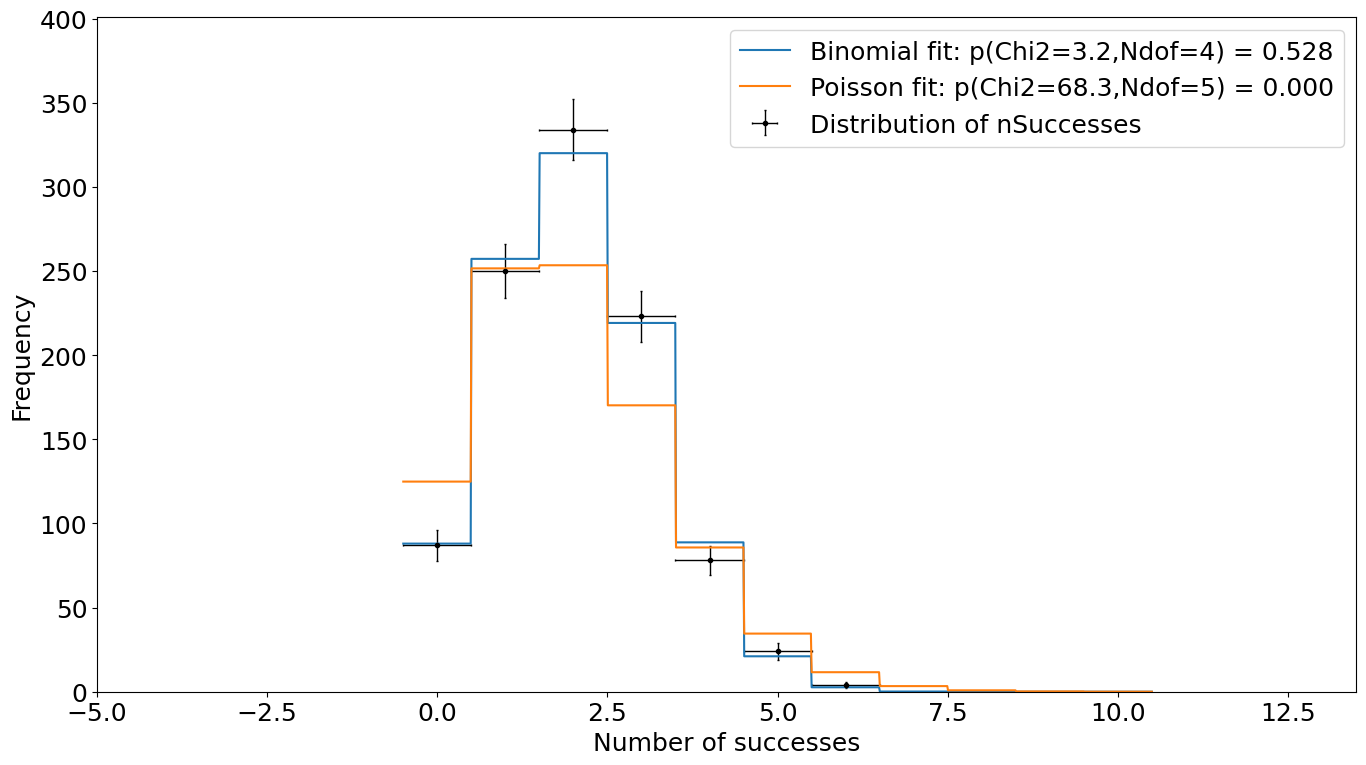

In [132]:
yaxis = func_poisson(np.floor(xaxis+0.5), *mfit_poisson.values[:])
ax.plot(xaxis, yaxis, '-', label=f'Poisson fit: p(Chi2={Chi2_poi:.1f},Ndof={Ndof_poi:d}) = {Prob_poi:.3f}')
ax.legend()
fig.tight_layout()
fig

## Fitting with a Gaussian:

In [133]:
def func_gaussian(x, N, mu, sigma) :
    return N * norm.pdf(x, mu, sigma)

In [134]:
chi2_gaussian = cost.LeastSquares(x, y, sy, func_gaussian)
mfit_gaussian = Minuit(chi2_gaussian, N=N_experiments, mu=Lambda, sigma=np.sqrt(Lambda)) #   
mfit_gaussian.migrad();         # Perform the actual fit
Chi2_gau = mfit_gaussian.fval
Ndof_gau = len(x) - 3           # 3 parameters in fit
Prob_gau = stats.chi2.sf(Chi2_gau, Ndof_gau)

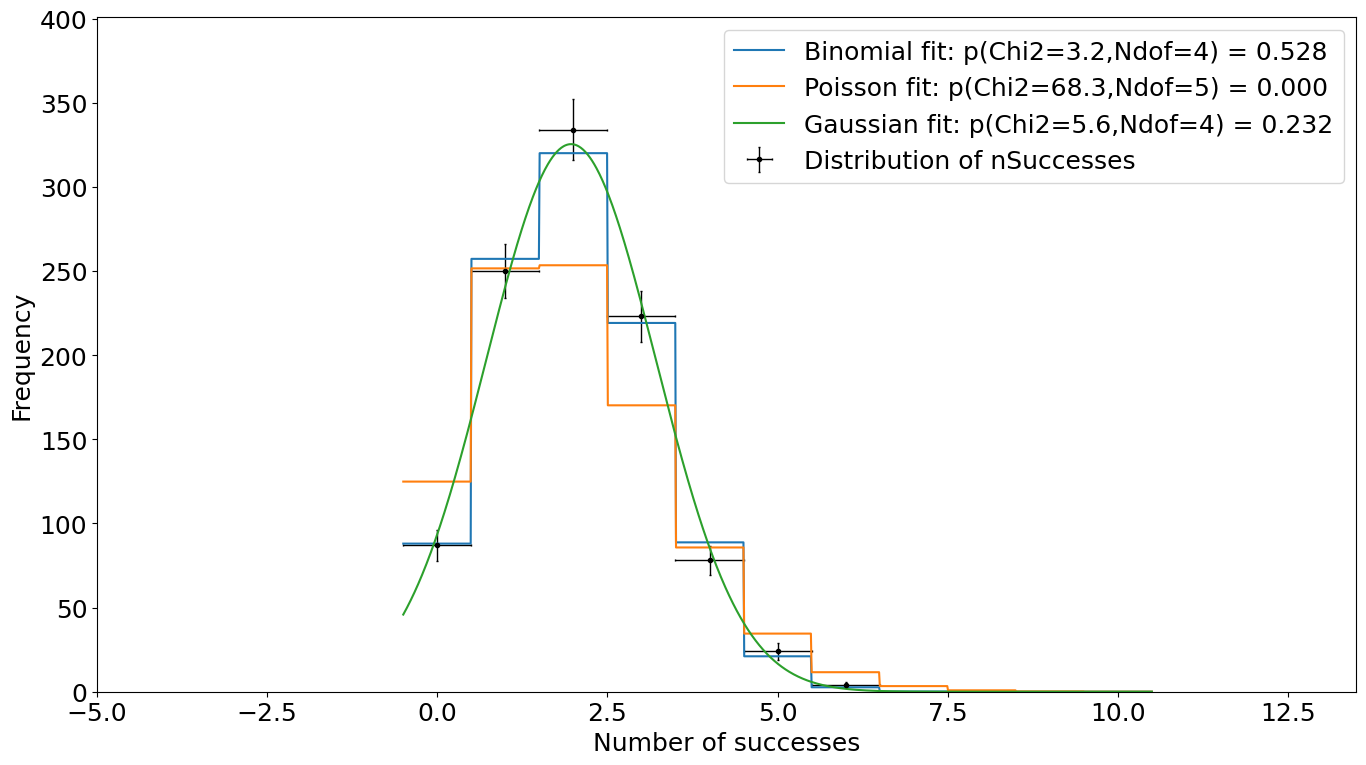

In [135]:
yaxis = func_gaussian(xaxis, *mfit_gaussian.values[:])
ax.plot(xaxis, yaxis, '-', label=f'Gaussian fit: p(Chi2={Chi2_gau:.1f},Ndof={Ndof_gau:d}) = {Prob_gau:.3f}')
ax.legend()
fig.tight_layout()
fig

And save the figure:

In [ ]:
if save_plots: 
    fig.savefig("BinomialPoissonGaussian.pdf")

## Calculation of Binomial $\chi^2$-value:

In this part of the exercise, you are asked to calculate the ChiSquare value yourself, in order to ensure that you understand exactly what is going on!

Above, we have (using Minuit) *fitted* the distribution, but as we know the initial values, you should calculate the $\chi^2$-value between the data and the binomial they were generated from, i.e. with NO free parameters.

I suggest you use Pearson's $\chi^2$, and require `N_obs` > 0 to ensure, that there is no division by zero (which is a cardinal sin in programming)!

In [29]:
N_bins = len(x)                # Just to know how many bins to loop over
chi2_bino = 0.0                # This you'll add to
N_dof = 0                      

In [30]:
for N_obs, x_i in zip(y, x):
    N_exp = func_binomial_2(x_i, N_experiments, N_trials, p_success)
    if (N_obs > 0) :
        chi2_bino += 0.0       # Write the expression yourself!

# Also calculate Ndof and Prob:
Ndof_bino = 1                  # Think about/write the number of degrees of freedom given no free parameters!
Prob_bino = 0.1010101010       # Calculate this yourself

In [31]:
print(f"Just a test printout, change to match your own results! \n")
print(f"Binomial:   chi2 = {chi2_bino:.2f}   N_dof = {Ndof_bino:d}   Prob = {Prob_bino:6.4f}")

Just a test printout, change to match your own results! 

Binomial:   chi2 = 0.00   N_dof = 1   Prob = 0.1010


***


# Questions:

Important: Make sure you understand what process yields a Binomial, a Poisson and a Gaussian distribution. Without this knowledge, this exercise and a large fraction of the course will be lost on you!

1. Plot a Binomial ($N=20$, $p=0.2$), Poisson ($\lambda = 4$), and Gaussian ($\mu=4$, $\sigma=\sqrt{4}$), i.e. same means and widths. Which distribution has the longest tail towards high values? And which one has the longest tail the other way? Does this pattern depend on the parameters (given same means and widths)? Play around with the settings (remember also to change the scale (use log) of the plot accordingly), and gain your own experience. And most importantly perhaps, in what limits do they start looking like each other?

##### Answer 1
The poisson distribution has the longest tail towards the higher values, and the gauss has longer tails in the other direction. 

The binomial distribution becomes the poisson distribution in the limit where N -> inf (maybe 50) and p -> 0 (0.1 is fine). In this limit N*p -> lambda, which then is the number of succesful outcomes. Lambda is then the number of cases you have counted as succesful, and having this number there is no need to know N or p. When lambda is bigger than 20 (royghly, can be smaller than that) the poisson also becomes a gaussian distribution. So for N -> inf, p -> 0 and lambda -> 20 or more, a distribution will have equal p-values for all types of fits. 

Sigma also changes, depending on which type of distribution you have. Sigma for a binomial dist. is np.sqrt(n*p*(1-p)), but of course in the limit where p is really small (Poisson), this is basically just np.sqrt(n*p).

2. Producing binomially distributed numbers (using the parameters `N_experiments=1000`, `N_trials=10` and `p_success=0.2`), do $\chi^2$ fits of the resulting distribution with a Binomial, a Poisson, and a Gaussian distribution. Do you get acceptable fit probabilities with all of these? If not, investigate for what choice of parameters you do.

##### Answer 2
For the given numbers the poisson is not a good fit. This is because a poisson requires low p high N, which we do not have in this instance. Tweaking the parameters to fit all requirements for being gaussian as a binomial, we can get them all good. 

3. Calculate the $\chi^2$ between the data and the original Binomial distribution (which the data is generated from). Since you are not fitting anything, what is the number of degrees of freedom? Does it give a reasonable $\chi^2$-probability?

4. In all of the above $\chi^2$ fits, we have _assumed_ that the uncertainty on the count in each bin is Gaussianly distributed! Ask yourself to what extend this requirement is fulfilled? Does changing the parameters (`N_experiments`, `N_trials` and `p_success`) "help" fulfilling this requirement, and if so, which and how?

### Advanced questions:

5. Using `N_experiments=1000`, `N_trials=1000` and `p_success=1/60`, is the skewness consistent with zero (as the Gaussian should have)?

# Learning points:

Generally, you should understand the concept of a PDF, and that there are many such, though in this course we only consider 10 or so. Some are *continuous* (e.g. exponential and Gaussian) and some are *discrete* (e.g. Binomial and Poisson).

In this exercise, you should have learned:
1. What the conditions leading to a Binomial and a Poisson distribution are.
2. In what limit of $N_{trials}$ and $p_{succes}$ the Binomial converges towards the Poisson.
3. That in the limit of $N_{trials} \times p_{succes} \to \infty$ and $\lambda \to \infty$, the two distributions become Gaussian (though discrete).
4. **That the uncertainty on a Poisson number is the square root of that number**.

One consequence of 4), is that we choose number of counts in a bin $N$ to have $\sqrt{N}$ as uncertainty. It should be noted, that for low $N$, the uncertainty is not very Gaussian.

You should also have learned how to choose binning when making a histogram of integers. 